In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_circuit_layout, circuit_drawer
import matplotlib as plt
import numpy as np
import random


In [ ]:
# functions

# def generate_bell_pair(m):
#     bell_pairs = []
#     for _ in range(m):
#         # create two qubits and two classical bits to store measurement results
#         qc = QuantumCircuit(2, 2)
#         qc.x(1)
#         qc.h(0)
#         qc.z(0)
#         qc.z(1)
#         qc.cx(0, 1)
        
#         bell_pairs.append(qc)
#         # print(qc)
#     return bell_pairs

def create_EPR_pairs(m):
    num_qubits =  2 * m
    qc = QuantumCircuit(num_qubits, num_qubits)

    for i in range(m):
        A = 2 * i
        B = 2 * i + 1

        qc.h(A)
        qc.cx(A, B)
        qc.z(A)


    return qc


def select_photons_eavesdropping(m, pe=0.2):

    # calculate number of pairs to consider for eavesdropping detection
    # so, pe is probability of not selected a qubit for measurement
    num_samples = (1 - pe) * m / 2
    num_samples = max(1, int(num_samples))

    # get random sample of indices based on proportion
    selected = np.random.choice(m, num_samples, replace=False)

    return selected

# https://quantumcomputing.stackexchange.com/questions/13605/how-to-measure-in-another-basis
def apply_random_measurements(qc, indices):

    bases = {}

    for i in indices:
        basis = random.choice(['X', 'Y', 'Z'])
        bases[i] = basis

        # get bob's qubit
        q = 2 * i + 1
        if basis == 'X':
            qc.h(q)
        elif basis == 'Y':
            qc.sdg(q)
            qc.h(q)

        # qiskit measures in z basis by default
        # only measure bob's qubit
        qc.measure(q, q)

    return bases

def eavesdropping_detection(qc, indices, simulator):

    bob_bases = apply_random_measurements(qc, indices)
    bob_results = {}

    qc = transpile(qc, simulator)
    job = simulator.run(qc, shots=1)
    result = job.result().get_counts()

    result_str = list(result.keys())[0]

    for i in indices:
        bob_results[i] = result_str[2 * i + 1]

    return bob_bases, bob_results

# e.g:
    # result.get_counts()
    # {'01011000': 1}
    # bob's qubits are at 1,3,5,7


# def eavesdropping_detection(qc, indices, simulator):
#     bob_bases = {}
#     bob_results = {}

#     for i in indices:
#         # apply measurements using Bob's qubit
#         bob_bases[i] = apply_random_measurements(bell_pairs[i], 1)
#         circ = transpile(bell_pairs[i], simulator) # transpile does some sort of optimization on simulator
#         job = simulator.run(circ, shots=1) # run the quantum circuit on the simulator; shots is number of executions
#         result = job.result().get_counts()
#         # print(result)
#         # print(result.keys())

#         # result -> {'01': 1} -> observed 01 one time
#         # result.keys() returns all measured bitstrings -> dict_keys(['01'])
#         #       list(result.keys())[0][1] -> ['01'] -> '01' -> '1' (return qubit in S_B)
#         list(result.keys())[0][1]
#         bob_results[i] = list(result.keys())[0][1]

#     return bob_bases, bob_results


def error_check(qc, simulator, indices, bob_bases, bob_results, threshold=0.1):

    alice_results = {}

    for i in indices:
        # alice's qubit
        q = 2 * i
        basis = bob_bases[i]

        if basis == 'X':
            qc.h(q)
        elif basis == 'Y':
            qc.sdg(q)
            qc.h(q)

        # only measure alice's qubit
        qc.measure(q, q)

    qc = transpile(qc, simulator)
    job = simulator.run(qc, shots=1)
    result = job.result().get_counts()

    result_str = list(result.keys())[0]

    for i in indices:
        alice_results[i] = result_str[2 * i]

    print("Alice Results: ", alice_results)

    error_count = 0
    for i in indices:
        if alice_results[i] == bob_results[i]:
            error_count += 1
    
    error_rate = error_count / len(indices)

    return not (error_rate  < threshold)



# step 3 encode
def encode(qc, message):
    for i, bit in enumerate(message):
        qubit = 2 * i # Alice's qubit

        if bit == "1":
            qc.x(qubit)
    
    # need to encode phase shift too

    return qc




def run_qisac(m, data, pe=0.1):

    simulator = AerSimulator()

    # step 1
    qc = create_EPR_pairs(m)

    # step 2
    # alice "sends" bob half of the pairs (S_B)
    # bob randomly selects photons from sequence S_B
    # select_photons_eavesdropping(m)
    # pe is probability of not selected a qubit
    indices = get_random_indices(m, pe)
    bob_bases, bob_results = eavesdropping_detection(qc, indices, simulator)

    print("Bob Bases: ", bob_bases)
    print("Bob Results: ", bob_results)

    is_error = error_check(qc, simulator, indices, bob_bases, bob_results)

    print("Is error: ", is_error)


# util functions

def get_random_indices(m, pe):
    # calculate number of pairs to consider for eavesdropping detection
    # so, pe is probability of not selected a qubit for measurement
    num_samples = (1 - pe) * m / 2
    num_samples = max(1, int(num_samples))

    print("Num samples: ", num_samples)

    # get random sample of indices based on proportion
    selected = np.random.choice(m, num_samples, replace=False)
    return selected




In [6]:
run_qisac(1, "hello", 0.1)

Num samples:  1
Bob Bases:  {np.int64(0): 'Y'}
Bob Results:  {np.int64(0): '0'}
Alice Results:  {np.int64(0): '0'}
Is error:  True


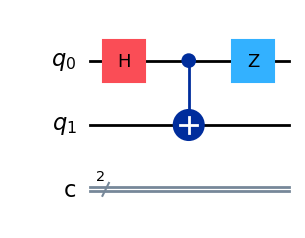

In [7]:
qc = create_EPR_pairs(1)

qc.draw('mpl')

In [ ]:
adc_values = [3598.125, 3605.000, 3601.500]

## Step 1: Prepare states

generate m circuits where each circuit is a bell pair in state |ψ−⟩⊗m
each circuit is in a list

## Step 2: First eavesdropping

select a random subset of bits to be used for error detection
bob randomly measures these bits in a randomly selected basis
Alice measures the corresponding bits using the same bases chosen by Bob
They compare results - should get opposite results using the bell state from the paper

## Step 3: Encoding
<!-- https://docs.quantum.ibm.com/guides/simulate-with-qiskit-sdk-primitives -->


